In [108]:
# %load qbo2netcdf.py
#!/usr/bin/python3
'''
Read QBO data from the following file: http://www.geo.fu-berlin.de/met/ag/strat/produkte/qbo/qbo.dat
'''

import numpy as np
import pandas as pd
import matplotlib.dates as mpl_dates
import datetime
import xarray as xr
import cftime
from dateutil.relativedelta import relativedelta


def read_singapore(nmonth, nyear, file_path='../QBO/qbo_data/singapore.dat'):
    headerlines = []
    ye = []
    dats = []
    date = []
    pressure = [100, 90, 80, 70, 60, 50, 45, 40, 35, 30, 25, 20, 15, 12, 10]
    altitude = -7 * np.log(np.array(pressure) / 1013.15)

    with open(file_path) as file:
        for i in range(3):
            headerlines.append(file.readline().strip())

        for year in range(1987, nyear):
            if year == nyear:
                data = np.zeros([nmonth, 15]) * np.nan
            else:
                data = np.zeros([12, 15]) * np.nan

            ye.append(file.readline().strip())
            file.readline()

            if year < 1997:
                for i in range(14):
                    cols = file.readline().strip().split()
                    for j in range(1, 13):
                        if i == 1:
                            date.append(datetime.datetime(year, j, 1))
                        data[j - 1, i] = float(cols[j])
            else:
                for i in range(15):
                    cols = file.readline().strip().split()
                    for j in range(1, 13):
                        if j < nmonth + 1 or year < nyear:
                            if i == 1:
                                date.append(datetime.datetime(year, j, 1))
                            data[j - 1, i] = float(cols[j])

            dats.extend(data.tolist())
            file.readline()

    fds = list(mpl_dates.date2num(date))
    fds = np.array(fds)
    
    return np.array(dats).T[::-1], fds, pressure, altitude, date


def read_qbo(file_path='../QBO/qbo_data/qbo.dat'):
    # Open the file to read the header
    with open(file_path, 'r') as file:
        # Read the first 9 lines and print them
        header_lines = [file.readline().strip() for _ in range(9)]
        # print("\n".join(header_lines))
    
    data = np.genfromtxt(file_path, skip_header=9,
                         dtype=['S6', 'S4', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1'],
                         names=['station', 'date', 'p70', 'n70', 'p50', 'n50', 'p40', 'n40', 'p30', 'n30', 'p20', 'n20', 'p15', 'n15', 'p10', 'n10'],
                         delimiter=[6, 4, 6, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2],
                         filling_values=-999999, missing_values=' ')

    station = np.char.strip(np.char.decode(data['station'], 'utf-8')).astype(str)

    # Convert date strings to datetime objects
    date = []
    station = []
    for i in range(len(data)):
        station.append(data['station'][i])
        if int(data['date'][i]) > 5000:
            date.append(datetime.datetime.strptime('19'+(data['date'][i]).decode('UTF-8'),'%Y%m'))
        else:
            date.append(datetime.datetime.strptime('20'+(data['date'][i]).decode('UTF-8'),'%Y%m'))

    fds = mpl_dates.date2num(date)

    #date = [datetime.datetime.strptime(('19' if int(year) > 5000 else '20') + year.decode('UTF-8') + month.decode('UTF-8'), '%Y%m') for year, month in zip(data['date'], data['date'])]
    #fds = mpl_dates.date2num(date)
    up = np.array([data['p70'], data['p50'], data['p40'], data['p30'], data['p20'], data['p15'], data['p10']])
    un = np.array([data['n70'], data['n50'], data['n40'], data['n30'], data['n20'], data['n15'], data['n10']])
    
    pressure = [70, 50, 40, 30, 20, 15, 10]
    altitude = -7 * np.log(np.array(pressure) / 1013.15)
    
    return up, fds, pressure, altitude, station, un, date


def convert2netcdf(date, dateaddmonth, u, pressure, fname, station):
    # Define station information
    station_info = {
        '91700': {'name': 'CANTON ISLAND', 'latitude': -(2 + 46 / 60), 'longitude': -(171 + 43 / 60)},
        '48968': {'name': 'SINGAPORE', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60},
        '48698': {'name': 'SINGAPORE', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60},
        '48964': {'name': 'SINGAPORE', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60},
        '48694': {'name': 'SINGAPORE', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60},
        '08694': {'name': 'SINGAPORE', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60},
        '43599': {'name': 'GAN/MALEDIVES', 'latitude': -(41 / 60), 'longitude': 73 + 9 / 60},
    }

    # Extract station information based on station codes
    station_id = [s_code for s_code in station]
    station_name = [station_info[s_code]['name'] for s_code in station_id]
    latitude = [station_info[s_code]['latitude'] for s_code in station_id]
    longitude = [station_info[s_code]['longitude'] for s_code in station_id]

    # Create xarray dataset
    ds = xr.Dataset({
        'u': (['time', 'pressure'], u),
        'station_id': (['time'], np.array(station_id, dtype='int32')),     # Convert station_id and station_name to numpy arrays
        'station_name': (['time'], np.array(station_name, dtype='S13')),  # Assuming a maximum string length of 13, adjust as needed
        'latitude': (['time'], latitude),
        'longitude': (['time'], longitude),
        'time_bnds': (['time', 'nv'], np.array([date, dateaddmonth]).T),
    },
    coords={
        'pressure': pressure,
        'time': date,
        'nv': np.array([0, 1]), 
    })
    
    ds['station_id'].attrs = {'long_name': 'Station ID',
                              'units': '1'} 
    #ds['station_id'] = ds['station_id'].astype('int32')
    ds['station_name'].attrs = {'long_name': 'Station Name'}
    #ds['station_name'] = ds['station_name'].astype('str')

    # Create a new variable for the quality flag and add attributes for the quality flag variable
    ds['u_qc'] = xr.where((ds['u'] >= -200) & (ds['u'] <= 200), 0, 1).astype(np.int32)
    ds['u_qc'].attrs = {'long_name': 'Quality flag for eastward wind', 'flag_values': np.array([0, 1], dtype=np.int32), 'flag_meanings': 'interpolated missing'}

    # Create time_bounds variable with appropriate shape
    #time_bounds = xr.DataArray(
    #    np.array([date, dateaddmonth]).T,
    #    dims=['time', 'bounds'],
    #)

    # Create the 'time_bounds' variable and add the 'time_bounds' variable to the dataset's coordinates
    #ds['time_bounds'] = time_bounds
    ds['time_bnds'].attrs = {'long_name': 'Time Bounds', 
                             #'standard_name': 'time_bounds',
                             'units': 'days since 1950-01-01 00:00:00'}
    # Add attributes for 'nv'
    ds['nv'].attrs = {'long_name': 'Number of Vertices in Bounds', 'units': 'count'}

    #ds.coords['time_bounds'] = time_bounds

    # Store the time bounds in the 'bounds' attribute of the 'time' variable
    ds['time'].attrs = {'standard_name': 'time', 
                        'long_name': 'Time', 
                        'units': 'days since 1950-01-01 00:00:00', 
                        'calendar': 'standard',  # You can adjust the calendar type based on your data
                        'cell_methods': 'time: mean (interval: 1 month)',
                        'bounds': 'time_bnds'}
    ds['pressure'].attrs = {'standard_name': 'air_pressure', 
                            'long_name': 'Atmospheric Pressure', 
                            'units': 'hPa', 
                            'axis': 'Z'}
    ds['u'].attrs = {'standard_name': 'eastward_wind', 
                     'long_name': 'Eastward Wind', 
                     'units': 'm/s', 
                     'cell_methods': 'time: mean (interval: 1 month)',
                     '_FillValue': np.nan, 
                     'u_qc': 0}

    # Add attributes for latitude and longitude variables
    ds['latitude'].attrs = {'long_name': 'Station Latitude', 'standard_name': 'latitude', 'units': 'degrees_north'}
    ds['longitude'].attrs = {'long_name': 'Station Longitude', 'standard_name': 'longitude', 'units': 'degrees_east'}

    #ds['time'].attrs['interval'] = '1 month'
    #ds['u'].attrs['interval'] = '1 month'
    # Add global attributes
    ds.attrs = {
        'Conventions': 'CF-1.8 CF-1.6 CF-1.7 IOOS-1.2 ACDD-1.3',
        'title': 'Monthly mean zonal winds',
        'summary': 'Collection of tropical winds originally from the FU Berlin to represent QBO data',
        'history': 'Created by Tobias Kerzenmacher using FUB processing chain',
        'source': 'FUB and Singapore radiosondes',
        'comment': 'Monthly mean zonal winds at the levels 100, 90, 80, 70, 60, 50, 45, 40, 35, 30, 25, 20, 15, 12, and 10-hPa from Radiosonde data of the three radiosonde stations Canton Island (closed 1967), Gan/Maledive Islands (closed 1975), and Singapore near the equator from 1953 to the present.',
        'institution': 'Karlsruhe Institute of Technology (KIT), Institute of Meteorology and Climate Research (IMK), Germany',
        'institution_id': 'ROR:04t3en479',
        'license': 'CC-BY 4.0',
        'keywords': 'QBO, radiosonde, zonal wind',
        'frequency': '1M',
        'creator_url': 'https://orcid.org/0000-0001-8413-0539',
        'creator_email': 'kerzenmacher@kit.edu',
        'contact': 'kerzenmacher@kit.edu',
        'creation_date': datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        'further_info_url': 'https://www.atmohub.kit.edu/english/807.php',
        'references': 'Barbara Naujokat (1986) doi: https://doi.org/10.1175/1520-0469(1986)043<1873:AUOTOQ>2.0.CO;2 Christian Marquardt (1998) Die tropische QBO und dynamische Prozesse in der Stratosphäre. PhD Thesis, Met. Abh. FU-Berlin, Serie A, Band 9/Heft 4, Verlag Dietrich Reimer Berlin, 260 S.',
        'standard_name_vocabulary': 'CF Standard Name Table, Version 83',
        'crs': 'wgs84'
    }

    # Change the data type of certain variables
    ds['pressure'] = ds['pressure'].astype(np.float64)
    ds['time'] = ds['time'].astype(np.float64)
    ds['time'] = ds['time'].astype(np.int32)
    ds['u'] = ds['u'].astype(np.float64)
    ds['time_bnds'] = ds['time_bnds'].astype(np.int32)
    ds['nv'] = ds['nv'].astype(np.int32)

    # Write to NetCDF file
    ds.to_netcdf(fname)

    return ds


# Read data from QBO
up1, fds1, pressure1, altitude1, station, un, da1 = read_qbo()

# Read data from Singapore
# In order to read the Singapore data, the end year and the fractional month are necessary
nmonth = np.shape(up1)[1] % 12  # number of months above a whole year
nyear = mpl_dates.num2date(fds1[-1]).year
if nmonth == 0: nyear = nyear +1
up2, fds2, pressure, altitude, da2 = read_singapore(nmonth, nyear)

# Create an empty array of eastward winds over 15 altitudes and the total number of months
tnmoth = np.shape(up1)[1]  # total number of months
up = np.zeros([15, tnmoth]) * np.nan

# Stack time data from QBO and Singapore
fds = fds1
fds[-fds2.size:] = fds2
fds = np.array(fds)

# Assemble eastward wind data into a single array for the QBO data only certain altitudes are present 
up1 = up1 * 1.  # Copy the array to avoid modifying the original data
up1[up1 < -10000] = np.nan
up[[3, 5, 7, 9, 11, 12, 14], :] = up1
#up[3,:]  = up1[0,:]
#up[5,:]  = up1[1,:]
#up[7,:]  = up1[2,:]
#up[9,:]  = up1[3,:]
#up[11,:] = up1[4,]
#up[12,:] = up1[5,:]
#up[14,:] = up1[6,:]

# Stack the Singapore data which are available at all altitudes at the end of the QBO data
#up[-up2.shape[0]:, -up2.shape[1]:] = up2
up = np.hstack((up[:, :-up2.shape[1]], up2))

# Convert date strings to datetime objects
time = mpl_dates.num2date(fds)

# Add one month to the date range so that time bounds can be defined
offset = relativedelta(months=1)
timeaddmonth = [pd.to_datetime(t) + offset for t in time]

# Convert dates to CFTime-compatible format
date = cftime.date2num(time, 'days since 1950-01-01 00:00:00', 'standard')
dateaddmonth = cftime.date2num(timeaddmonth, 'days since 1950-01-01 00:00:00', 'standard')

# Create netCDF file
fname = 'radiosonde_tropical_eastward_wind_{:04d}{:02d}.nc'.format(time[0].year, time[0].month)
ds = convert2netcdf(date, dateaddmonth, up.T * 0.1, pressure, fname, [x.decode("utf-8").strip() for x in station])


In [107]:
np.unique(date, return_counts="TRUE")
np.where(np.diff(date)<0)
#date[417:422]

(array([], dtype=int64),)

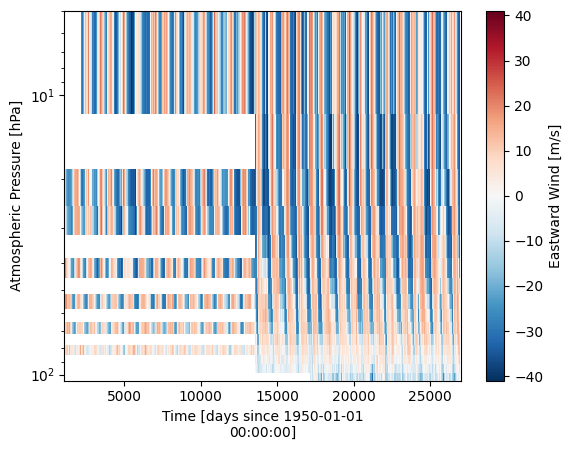

In [89]:
ds.u.plot.imshow(y='pressure',yscale='log', yincrease=False)